# Segmentação Interativa para Ferramentas de Anotação de Imagens Médicas aplicada à Citologia

## Contexto

### Citologia

* Técnica de diagnóstico médico pouco invasiva
* Células são colhidas do tecido do paciente
* Lâminas preparadas com corantes e analisadas ao microscópio

![Citologia](Lamina_citologia_p.png)

### Ferramentas de Anotação de Imagens Médicas

* Whole-Slide Imaging: lâminas físicas são digitalizadas
* Visualização de lâmina digital via software
* Ferramentas para patologistas anotarem regiões de interesse

![DIMP](dimp.jpg)

### Segmentação Interativa

* Usa cliques/caixas de seleção como entrada
* Menos trabalhosa que anotação manual
* Precisão da Inteligência Artificial

![NuClick](nuclick.png)

## Preparação da imagem a segmentar

### Dataset

Lâminas virtuais de amostras com coloração de Feulgen, com regiões de interesse anotadas e classificadas

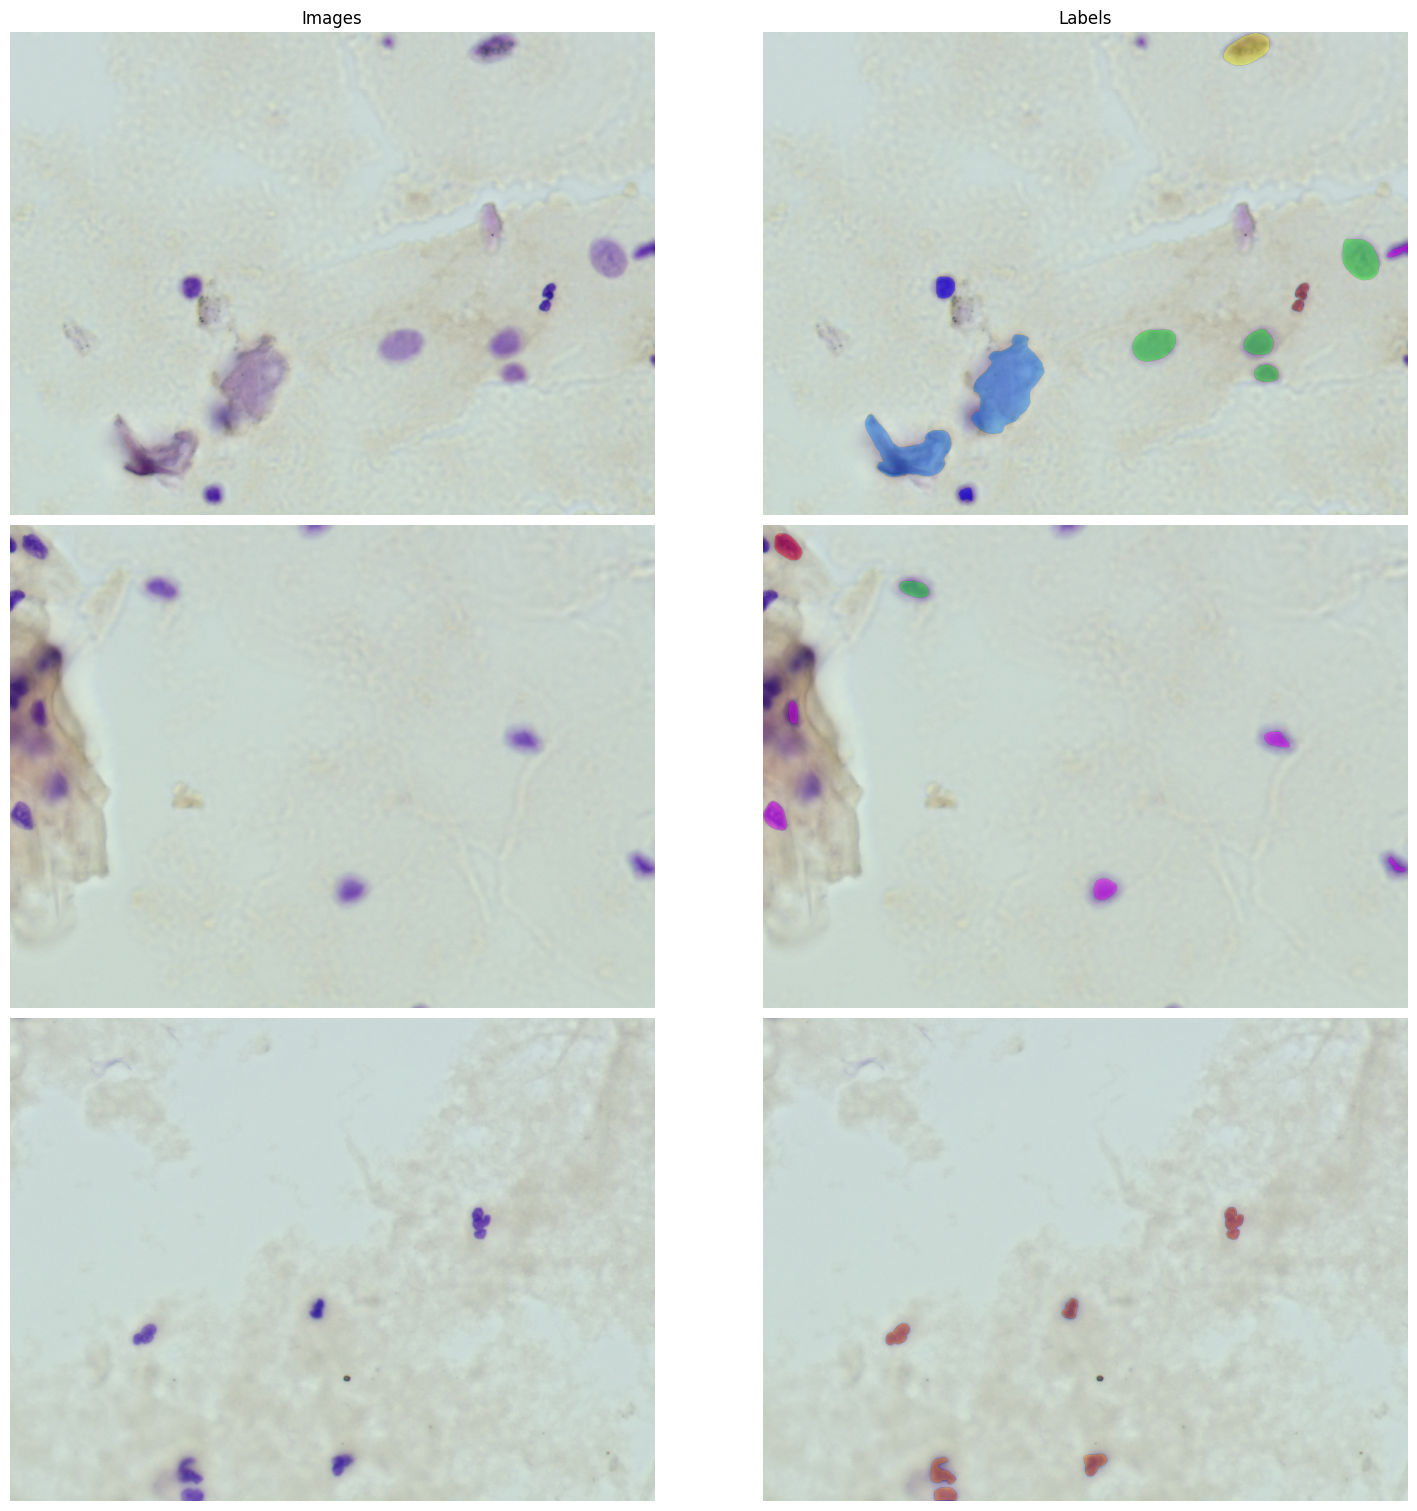

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

def get_colormap(t):
    return np.array([
            [0.0, 0.0, 0.0, 0.0],    # 0: Transparent
            [1.0, 0.0, 0.0, t],      # 1.0: Red
            [0.0, 1.0, 0.0, t],      # 2: Green
            [0.0, 0.0, 1.0, t],      # 3: Blue
            [1.0, 1.0, 0.0, t],      # 4: Yellow
            [0.0, 1.0, 1.0, t],      # 5: Cyan
            [1.0, 0.0, 1.0, t],      # 6: Magenta
            [1.0, 0.5, 0.0, t],      # 7: Orange
            [0.0, 0.5, 1.0, t],      # 8: Azure
        ])

def get_dataset_imgs(stage):
    if stage!="train" and stage!="val" and stage!="test":
        raise Exception(f"Stage must be 'train', 'val' or 'test', not {stage}")
    
    dataset_dir = Path("/lapix/arquivos/Datasets/OD_SS/")
    img_dir = "Images"
    label_dir = "SS_Labels"

    imgs = dataset_dir.joinpath(stage, img_dir).glob("*.png")
    
    return [(img, dataset_dir.joinpath(stage, label_dir, img.name)) for img in imgs]

# TESTE get_dataset_imgs
# print("Image, Label")
# for stage in ["train", "val", "test"]:
#     print(stage)
#     for img, lbl in get_dataset_imgs(stage):
#         print(img.exists(), lbl.exists(), img, lbl)

imgs_train = get_dataset_imgs("train")
imgs_subset = imgs_train[:3]

fig, axes = plt.subplots(nrows=len(imgs_subset), ncols=2, figsize=(15, 15), layout="constrained")
axes[0, 0].set_title("Images")
axes[0, 1].set_title("Labels")

colormap = get_colormap(0.4)
for i, (img_name, label) in enumerate(imgs_subset):
    img = imread(img_name)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(img)
    mask = imread(label)
    rgb_mask = colormap[mask]
    axes[i, 1].imshow(rgb_mask)
    
    axes[i, 1].axis('off')

plt.show()

### Escolha da imagem e do ponto simulando clique

In [2]:
from ipywidgets import interact
import numpy as np

target_img = None
target_click = (628, 708)

def show_mask(mask, alpha, ax):
    rgba_mask = get_colormap(alpha)[mask]
    ax.imshow(rgba_mask)

def show_image(image, point=None, ann=None, title=None, alpha=0.5):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    if not point is None:
        ax.scatter(point[0], point[1], color='lime', marker='.', s=200, edgecolor='red', linewidth=2.25)

    if not ann is None:
        show_mask(ann, alpha, ax)
        
    if title:
        plt.title(title, fontsize=18)
        
    plt.axis('on')
    plt.show()

def show_img_interact(index=114, x=628, y=708, ann_alpha=0.5):
    # pega imagem do indice "index"
    img_path = imgs_train[index][0]
    img = imread(img_path)

    # pega rotulos da imagem
    anns = imread(imgs_train[index][1])
    # trata todos os rotulos como do mesmo tipo
    # labels[labels > 1] = 1

    # pega ponto clicado simulado
    point = (x, y)

    # mostra imagem
    show_image(img, point, anns, img_path.name, ann_alpha)

    # atualiza valor das variaves para serem usados nas outras celulas
    # variavel da imagem
    global target_img
    target_img = img
    # variavel do ponto clicado 
    global target_click
    target_click = point

img_shape = imread(imgs_train[0][0]).shape
interact(show_img_interact, index=(0, len(imgs_train)), x=(0, img_shape[1]-1), y=(0, img_shape[0]-1), ann_alpha=(0.0, 1.0, 0.01));

interactive(children=(IntSlider(value=114, description='index', max=1565), IntSlider(value=628, description='x…

## Segmentação com Métodos Clássicos

## Purple Treshold

Segmenta separando pixels roxos ao redor da imagem:
* Filtra pixels roxos
* Erosão para separar áreas grudadas
* Separa áreas calculando componente conexas
* Dilatação das componentes conexas
* Obtém somente componente clicada

Dificuldades:
* Tendência a grudar objetos próximos
* Erosão faz desaparecer áreas pequenas
* Áreas com pixels roxos "apagados" somem

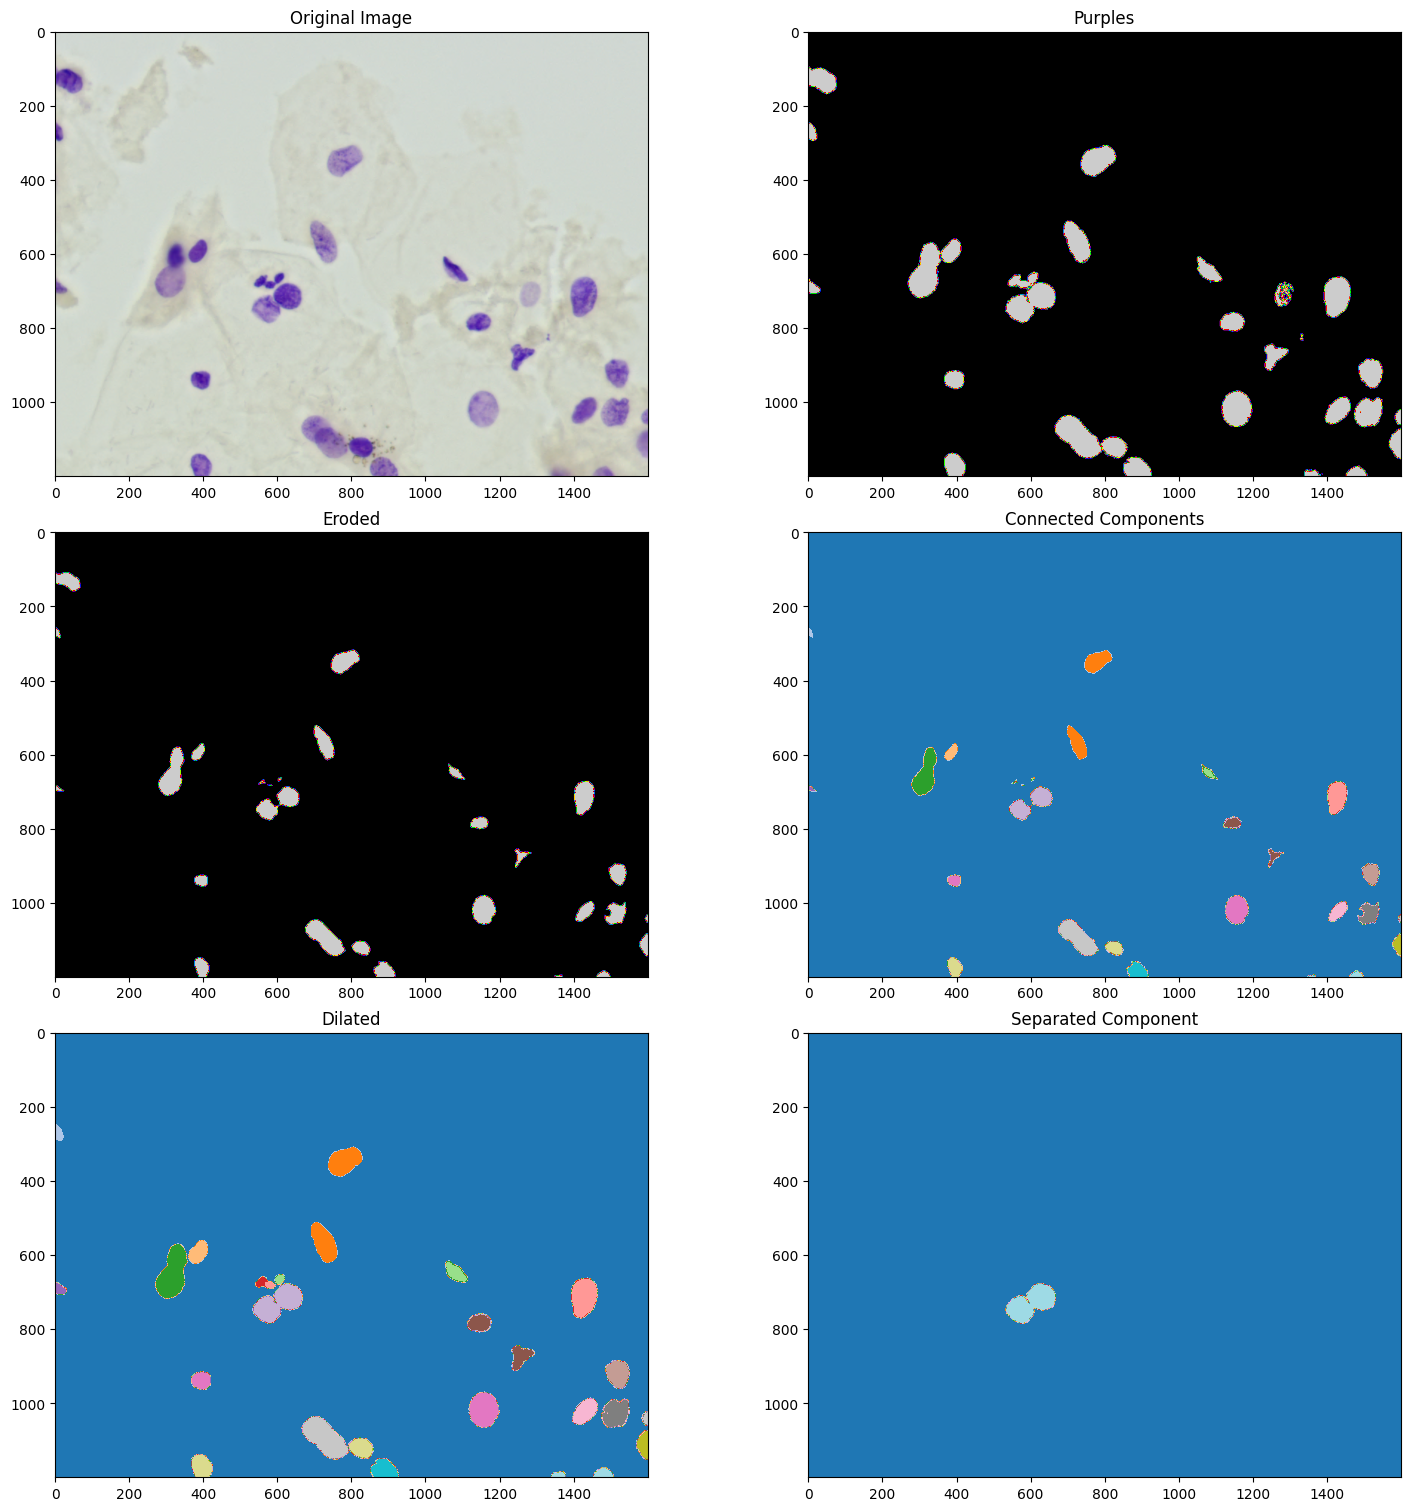

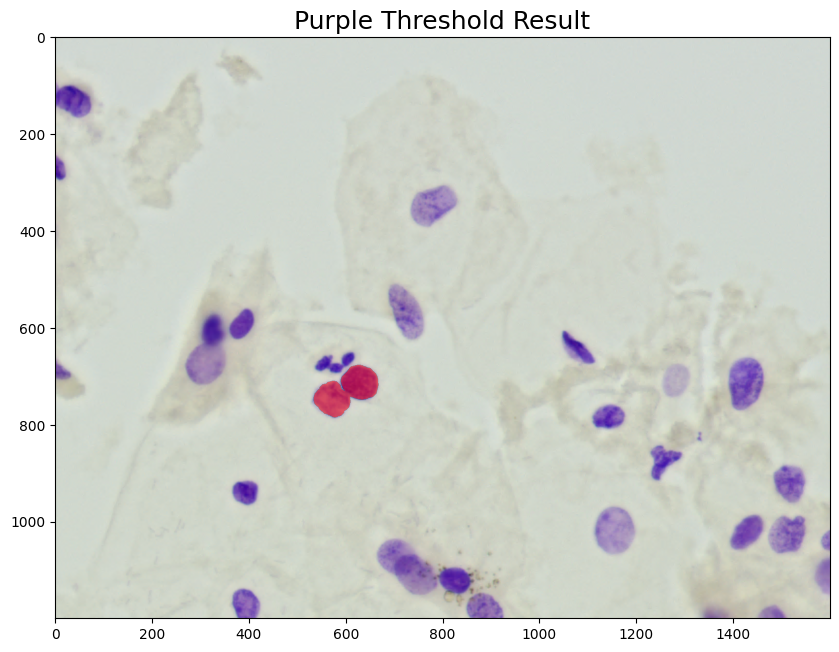

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.morphology import disk
from skimage.morphology import binary_erosion
from skimage.morphology import dilation

def is_purple(img):
    # Separar canais
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    
    # Definir as condições
    cond_b = (B >= 1.01 * R) & (B <= 5.00 * R)
    cond_g = (G >= 0.0 * R) & (G <= 0.96 * R)
    
    # Máscara combinada (onde ambas as condições são verdadeiras)
    return cond_b & cond_g

def purple_threshold(img, click, show=False):
    # obtem somente pixels roxos
    mask = is_purple(img)

    # erode mascara de pixels roxos
    fp = disk(9)
    eroded = binary_erosion(mask, footprint=fp)

    # divide pixels roxos erodidos em componentes conexas
    ccs = label(eroded)

    # dilata componentes conexas
    dilated = dilation(ccs, footprint=fp)

    # pega somente a componente do ponto clicado
    #print(f"{click} + {dilated.shape}")
    val_click = dilated[click[1], click[0]]
    cc_click = dilated.copy()
    cc_click[cc_click != val_click] = 0
    cc_click[cc_click == val_click] = 1
    #mask_rgba = np.array([[0.,0.,0.,0.],[1.,1.,0.,0.5]])[cc_click.astype('uint8')]

    # mostra passos
    if show:
        fig, axes = plt.subplots(3, 2, figsize=(15, 15), layout="constrained")
        
        axes[0, 0].imshow(img)
        axes[0, 0].set_title('Original Image')
        axes[0, 1].imshow(mask, cmap=plt.cm.nipy_spectral)
        axes[0, 1].set_title('Purples')
        axes[1, 0].imshow(eroded, cmap=plt.cm.nipy_spectral)
        axes[1, 0].set_title("Eroded")
        axes[1, 1].imshow(ccs, cmap=plt.cm.tab20)
        axes[1, 1].set_title("Connected Components")
        axes[2, 0].imshow(dilated, cmap=plt.cm.tab20)
        axes[2, 0].set_title("Dilated")
        axes[2, 1].imshow(cc_click, cmap=plt.cm.tab20)
        axes[2, 1].set_title('Separated Component')
    
        plt.show()

    return cc_click
    
purple_label = purple_threshold(target_img, target_click, True)
show_image(target_img, None, purple_label, "Purple Threshold Result")

### Watershed

Segmenta via watershed, usando o ponto clicado como semente:
* Entrada: gradientes da imagem
* Os gradientes menores são "vales" e os maiores como "montanhas"
* "Inunda" a imagem, partindo da semente, para encontrar as regiões

Dificuldades:
* Depende de método de detecção de borda
* Se há "furos" na borda em torno da semente, a água "vaza"
* "Vazamento" pode unir regiões próximas
* "Vazamento" pode fazer região encobrir imagem toda

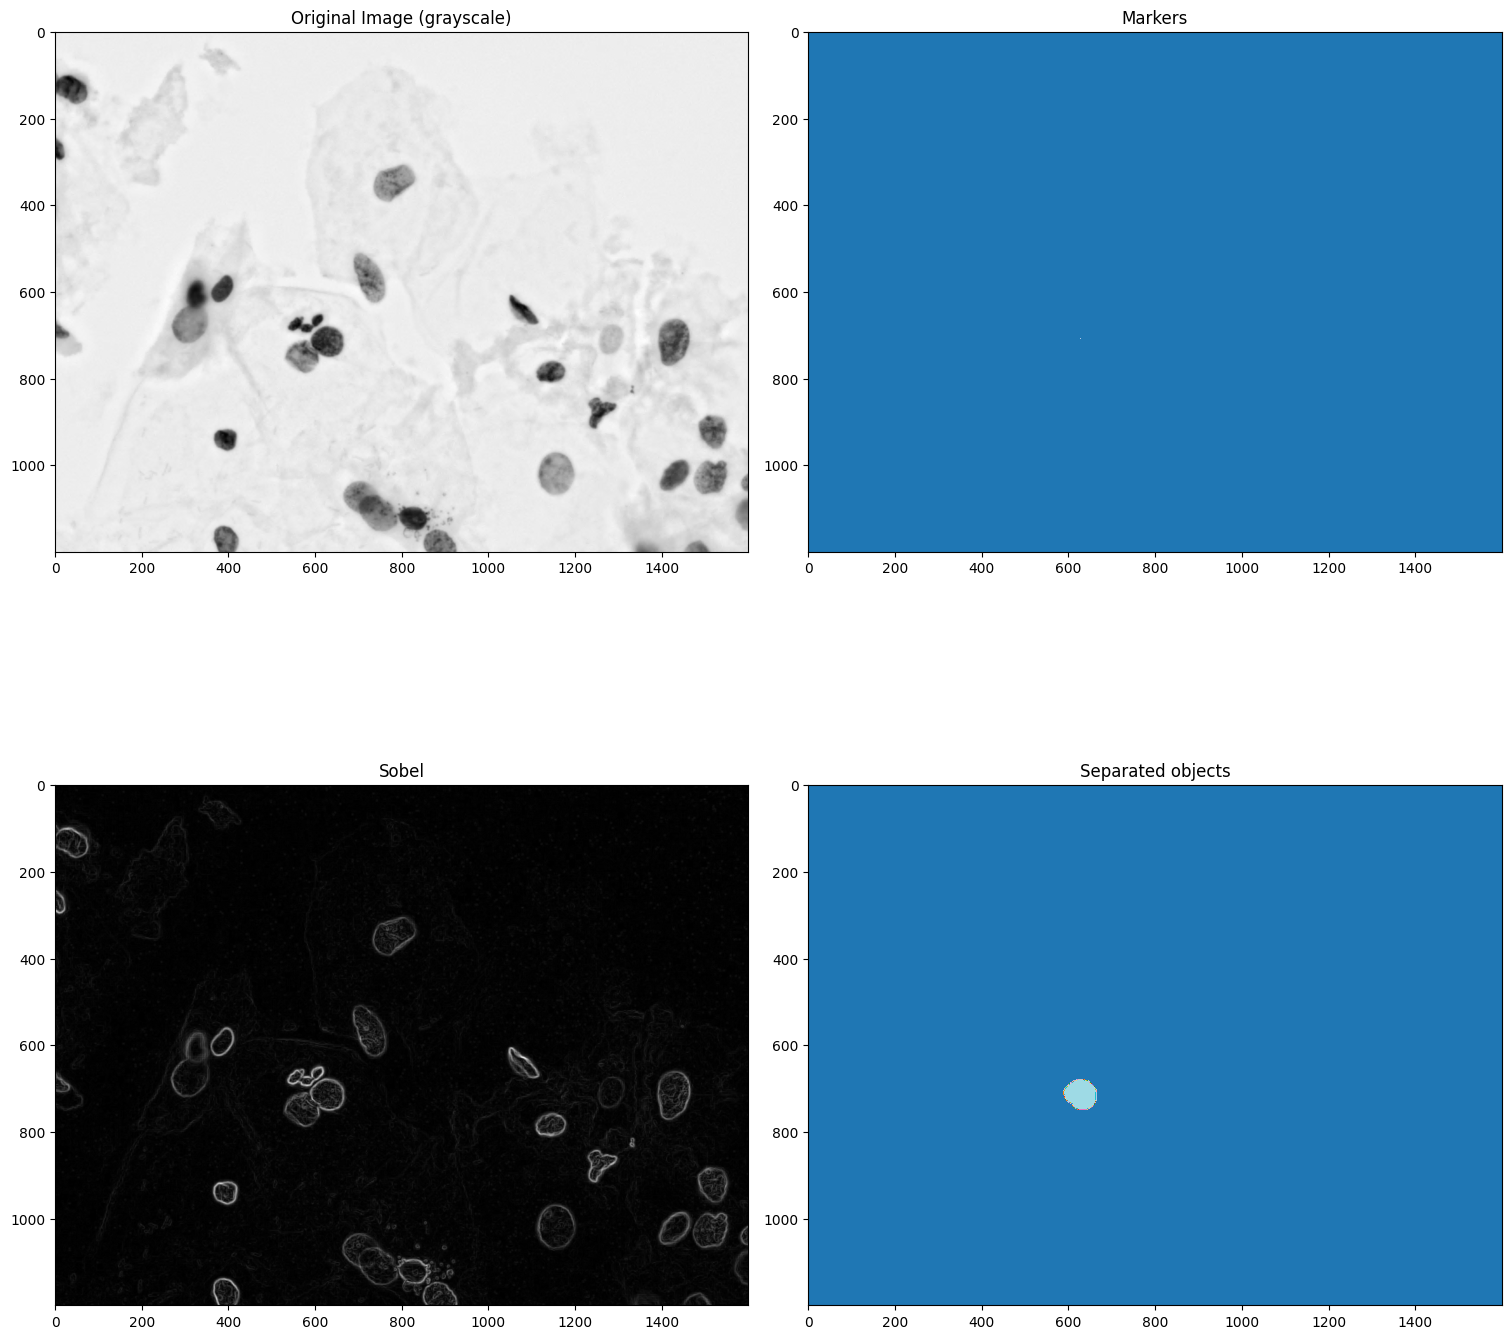

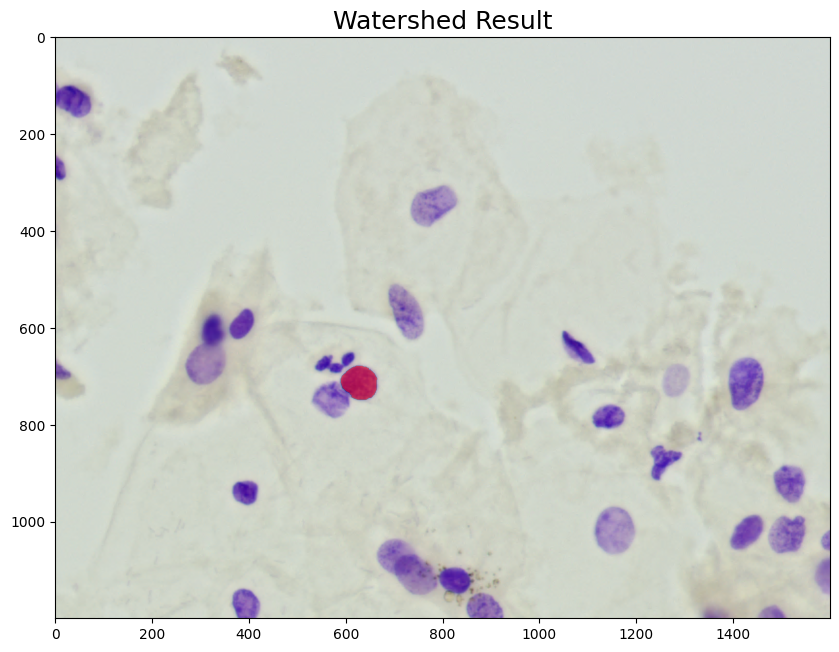

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage.feature import canny
from skimage.filters import sobel

def watershed_segment(image_rgb, point, gradient_method=None, show=False):
    # trabalha com imagem em escala de cinza
    image = rgb2gray(image_rgb)

    # escolhe metodo de deteccao de borada
    if (gradient_method == 'Canny'):
        input_image = canny(image)
    elif (gradient_method == 'Sobel'):
        input_image = sobel(image)
    else:
        input_image = image

    # cria mascara do tamanho da imagem com ponto indicando local da semente
    markers = np.zeros(np.shape(image), dtype=int)
    markers[point[1], point[0]] = 1
    markers[0, 0] = 2

    # usa watershed para obter imagem com a regiao rotulada
    labels = watershed(input_image, markers)

    # muda rotulos para que a regiao de interesse seja 1 e o resto seja 0
    label_value = labels[point[1], point[0]]
    labels[labels != label_value] = 0
    labels[labels == label_value] = 1

    # mostra passos
    if show:
        fig, axes = plt.subplots(2, 2, figsize=(15, 15), layout="constrained")
        
        axes[0, 0].imshow(image, cmap=plt.cm.gray)
        axes[0, 0].set_title('Original Image (grayscale)')
        axes[0, 1].imshow(markers, cmap=plt.cm.tab20)
        axes[0, 1].set_title('Markers')
        axes[1, 0].imshow(input_image, cmap=plt.cm.gray)
        axes[1, 0].set_title(gradient_method)
        axes[1, 1].imshow(labels, cmap=plt.cm.tab20)
        axes[1, 1].set_title('Separated objects')
    
        plt.show()

    return labels

watershed_label = watershed_segment(target_img, target_click, "Sobel", True)
show_image(target_img, None, watershed_label, "Watershed Result")

### Active Contour Model (Snakes)

Detecta contornos em objetos através de uma curva de referência, que se deforma até contornar o objeto
* Curva de referência é círculo ao redor do ponto clicado
* Círculo deve ser grande o suficiente para contornar a imagem
* Testa círculos cada vez maiores para detectar objetos de tamanhos diferentes
* Para de testar quando encontra área têm proporção de pixels "roxos" abaixo de limiar

Dificuldades:
* O método em si é lento
* Várias chamadas ao método, até encontrar círculo grande o suficiente
* Círculo grande pode capturar mais de um objeto
* Limiar pouco tolerante faz contornos menores que o desejado

Iteration 0
Iteration 1
Iteration 2
Iteration 3


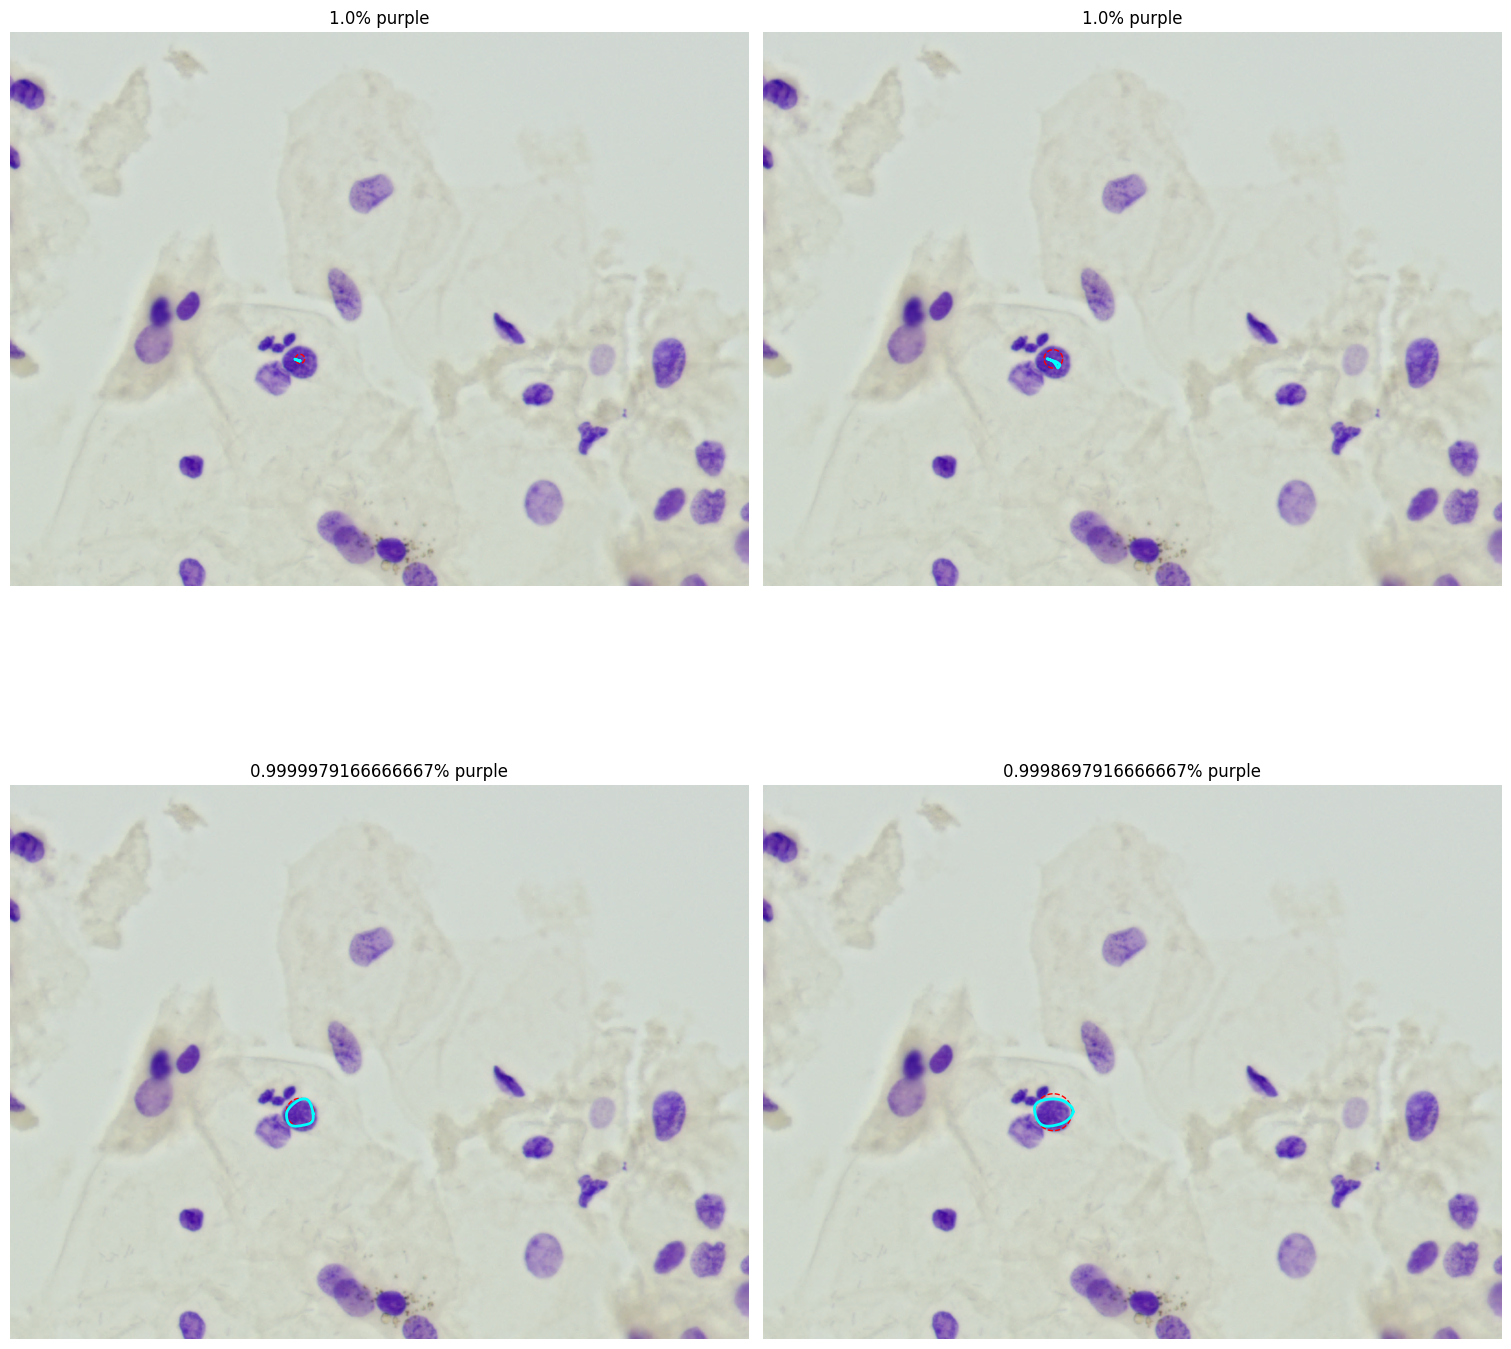

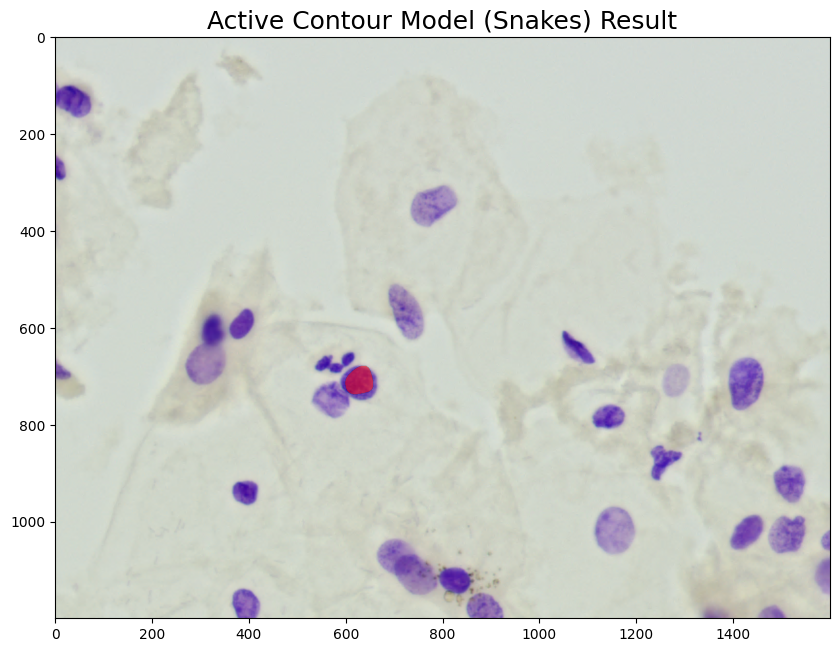

In [5]:
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import grid_points_in_poly

def acm_snake(img_rgb, x, y, raio):
    img_gray = rgb2gray(img_rgb)
    
    s = np.linspace(0, 2 * np.pi, 400)
    r = y + raio*np.sin(s)
    c = x + raio*np.cos(s)
    
    init = np.array([r, c]).T
    
    return init, active_contour(
        gaussian(img_gray, sigma=3, preserve_range=False),
        init,
        alpha=0.015,
        beta=10,
        gamma=0.001,
    )

def acm_snakes(img_rgb, point, init_radius, step_radius, max_iter, tolerance_rate, show=False, verbose=False):
    area_mask_old = np.zeros_like(img_rgb)
    area_mask_new = area_mask_old
    
    raio = init_radius
    inits = []
    snakes = []
    purple_rates = []

    for i in range(0, max_iter):
        if verbose:
            print(f"Iteration {i}")
        
        # obtem referencia inicial e contorno
        init, snake = acm_snake(img, point[0], point[1], raio)
        inits.append(init)
        snakes.append(snake)

        # aumenta raio caso precise executar denovo   
        raio = raio + step_radius
        
        # obtem area detro do contorno
        area_mask_old = area_mask_new
        area_mask_new = grid_points_in_poly(img_rgb.shape, snake, binarize=True)
        
        # obtem pixels dentro da area
        area_pixels = np.zeros_like(img_rgb)
        area_pixels[area_mask_new] = img_rgb[area_mask_new]

        # obtem pixels roxos
        area_purple = is_purple(area_pixels)

        # calcula proporcao de roxos sobre nao-roxos
        count_purple = np.sum(area_purple)
        total_pixels = area_purple.size
        
        purple_rate = count_purple / total_pixels if total_pixels > 0 else 0
        purple_rates.append(purple_rate)

        # sai fora se houve piora muito grande
        if purple_rate < tolerance_rate:
            break
                                        
    if show:
        maxi = (len(inits) + 1)//2
        fig, axes = plt.subplots(nrows=maxi, ncols=2, figsize=(15, 15), layout="constrained")
    
        for i in range(0, maxi):
            for j in range(0, 2):
                if maxi == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]
                        
                idx = 2*i+j
                if idx < len(inits):
                    init = inits[idx]
                    snake = snakes[idx]
                    ax.imshow(img_rgb)
                    ax.set_title(f"{purple_rates[idx]}% purple")
                    ax.plot(init[:, 1], init[:, 0], '--r', lw=1)
                    ax.plot(snake[:, 1], snake[:, 0], c="#00FFFF", lw=2)
                    ax.axis('off')
                else:
                    ax.set_visible(False)
    
        plt.show()

    return area_mask_old.astype('uint8')

snake_label = acm_snakes(target_img, target_click, init_radius=10, step_radius=10, max_iter=8, tolerance_rate=0.99995, show=True, verbose=True)
show_image(target_img, None, snake_label, "Active Contour Model (Snakes) Result")

## Segmentação com SAM-2

* Segmentação interativa
* Zero-shot: segmenta objetos que nunca viu
* Treinada sobre milhões de imagens anotadas
* 2 encoders: um para a imagem e outro para prompts
* Decoder gerar máscaras segmentadas

### Configurando SAM-2

In [6]:
!pip install git+https://github.com/facebookresearch/segment-anything-2.git

DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/paddleseg-0.0.0.dev0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-m0rk_2jc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-m0rk_2jc
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# carregando PyTorch

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        print("tfloat32")
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# print pytorch/cuda versions
print("PyTorch version:", torch.__version__)
# print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

using device: cuda
tfloat32
PyTorch version: 2.5.1+cu124
CUDA is available: True


In [8]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "SAM2/checkpoint_sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

### Segmentando imagem

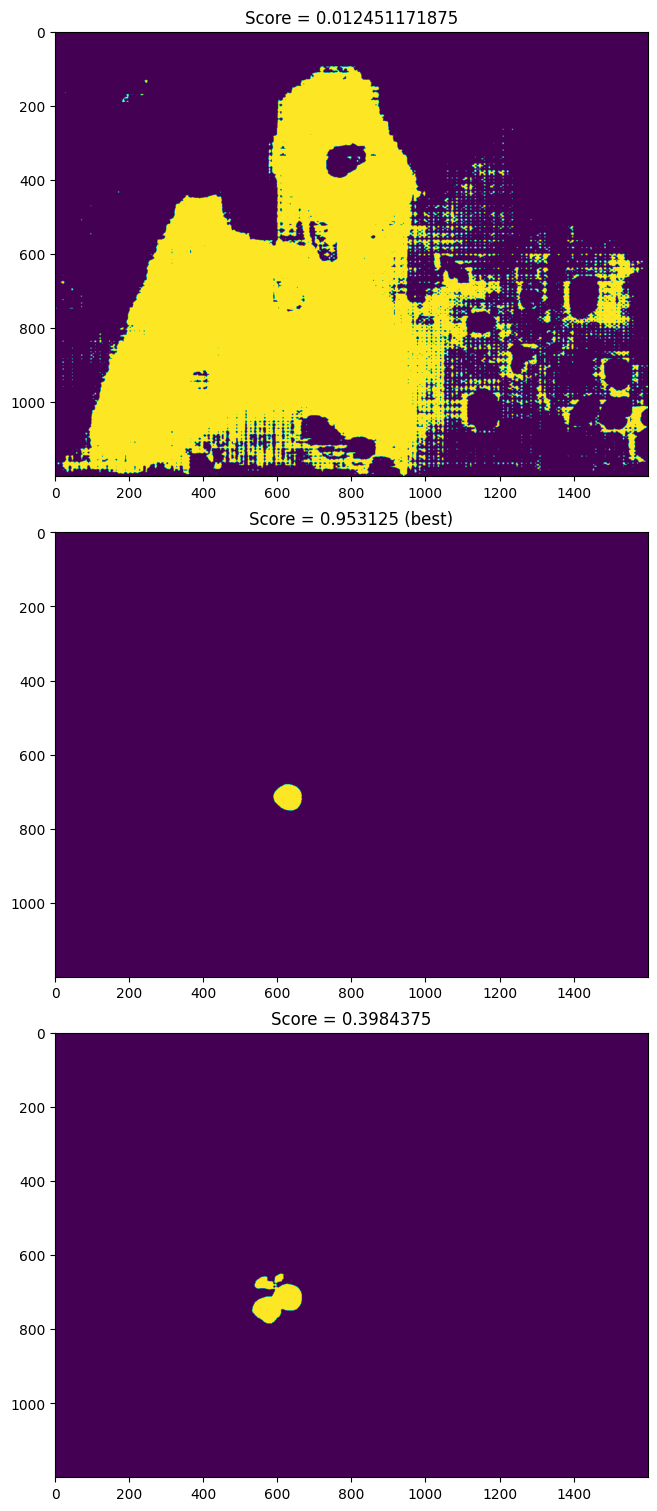

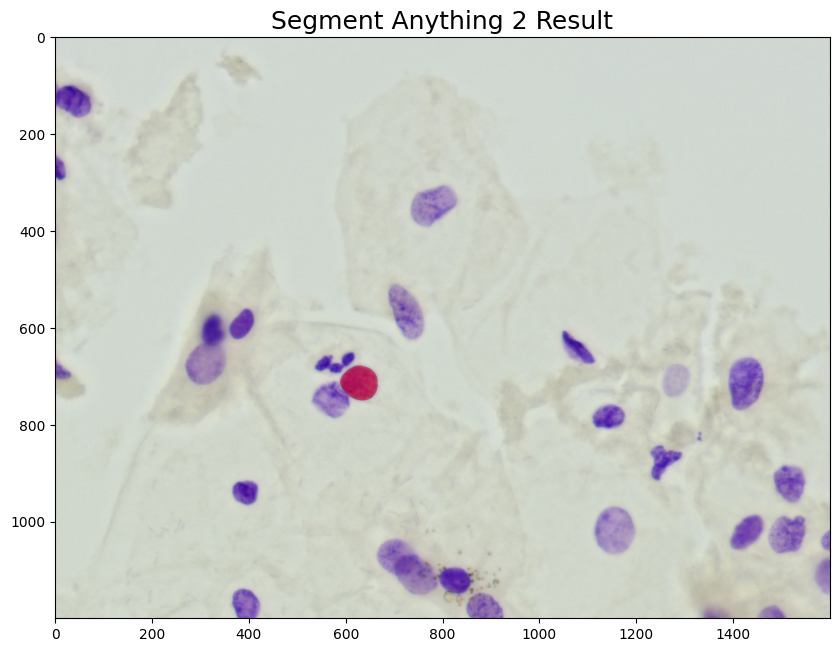

In [9]:
def sam2_segment(img, point, checkpoint_file, show=False):
    predictor = SAM2ImagePredictor(sam2_model)
    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)
        predictor.model.load_state_dict(checkpoint['model_state_dict'])
    
    predictor.set_image(img)
    masks, scores, logits = predictor.predict(
        point_coords=[point],
        point_labels=[1]
    )
    
    # pega a melhor das 3 predicoes
    best_index = np.argmax(scores)
    best_mask = masks[best_index]
    best_score = scores[best_index]
    
    # imprime resultados das predicoes
    if show:
        fig, axes = plt.subplots(3, figsize=(15, 15), layout="constrained")

        for i, ax in enumerate(axes):
            ax.imshow(masks[i])
            
            title = f"Score = {scores[i]}"
            if i == best_index:
                title = title + " (best)"
            ax.set_title(title)
    
        plt.show()
    
    #for i, score in enumerate(scores):
    #    best = "(best)" if score == best_score else ""
    #    print(f"Score {i+1}: {score} {best}")

    return best_mask.astype('uint8')

sam2_label = sam2_segment(target_img, target_click, None, True)
show_image(target_img, None, sam2_label, "Segment Anything 2 Result")

## Comparando Resultados

### Obtendo dados para testes: rótulo aleatório em imagem aleatória, com clique gerado em posição aleatória

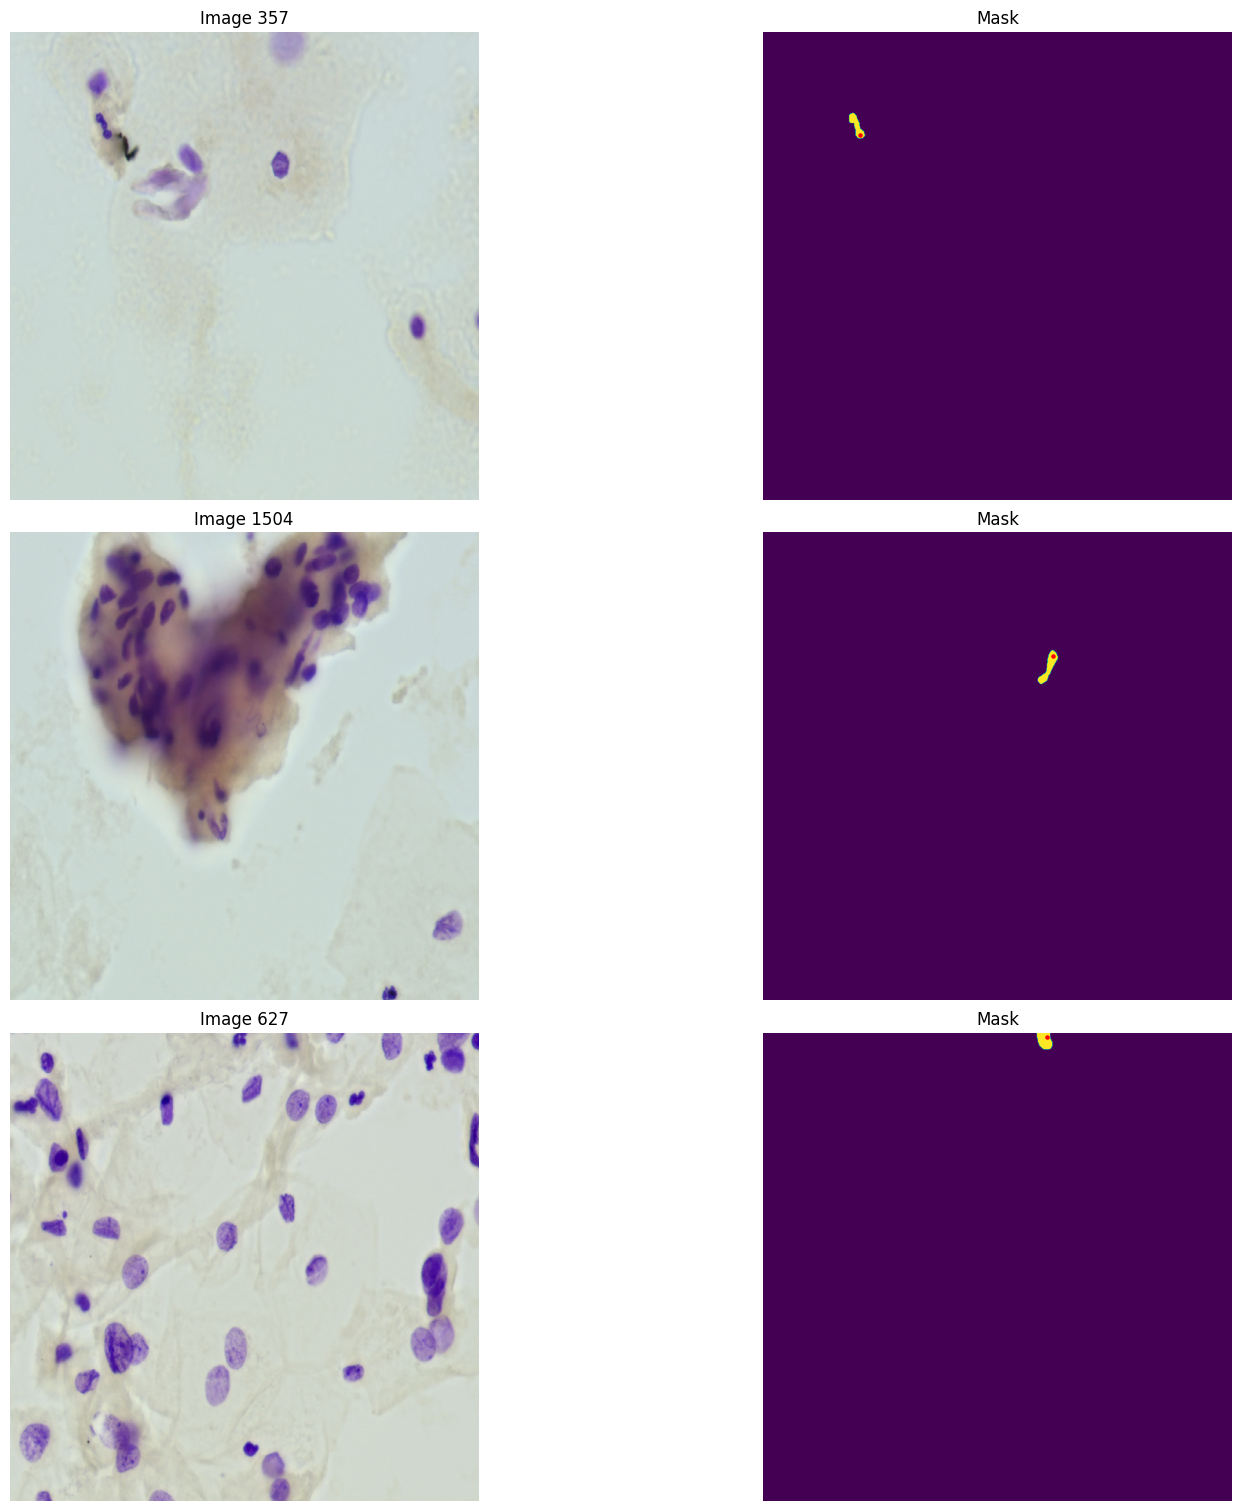

In [41]:
from skimage.transform import resize
from skimage.measure import centroid

# get single annotation from image, with a random point on it
def get_img_mask_point(data, idx, resize_img=None):
    img = imread(data[idx][0]) # read image
    ann = imread(data[idx][1]) # read annotation

    # resize image
    if resize_img:
        # resize_img deve ser tupla (1024, 1024) para fine-tuning
        img = resize(img, resize_img, order=0, anti_aliasing=False)
        ann = resize(ann, resize_img, order=0, anti_aliasing=False)
    
    # divide labels into connected components
    ann = label(ann)

    # get all connected component labels
    labels = np.unique(ann)
    labels = np.delete(labels, 0) # remove label 
    
    if len(labels) == 0:
        return get_img_mask_point(data, idx=idx, resize_img = resize_img)

    # get random label
    lbl = labels[np.random.randint(len(labels))]
    
    # make binary mask corresponding to label 'lbl'
    mask = (ann == lbl)

    # erode mask to generate points close to the center
    eroded_mask = binary_erosion(mask, disk(5))

    # choose random point/coordinate
    coords = np.argwhere(eroded_mask == True) # get all coordinates in mask

    # in erosion has destroyed the mask , choose the uneroded mask centroid as point
    yx = centroid(mask) if len(coords) == 0 else np.array(coords[np.random.randint(len(coords))]) 
        
    return img, mask.astype(np.uint8), [yx[1], yx[0]]

def get_random_batch(data, batch_size=4, resize_img=None):
    img_lst = []
    mask_lst = []
    point_lst = []
    idxs = []
    for i in range(batch_size):
        idx = np.random.randint(len(data))
        idxs.append(idx)
        image, mask, point = get_img_mask_point(data, idx, resize_img=resize_img)
        img_lst.append(image)
        mask_lst.append(mask)
        point_lst.append(point)
    
    return img_lst, np.array(mask_lst), np.array(point_lst), idxs

def show_batch(imgs, masks, points, indexes):
    rows = len(imgs)
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15, 15), layout="constrained")
    
    for i in range(0, rows):
        ax = axes if rows == 1 else axes[i]
        
        ax[0].imshow(imgs[i])
        ax[0].set_title(f"Image {indexes[i]}")
        ax[0].axis('off')
        
        ax[1].imshow(masks[i])
        ax[1].set_title(f"Mask")
        ax[1].scatter(points[i, 0], points[i, 1], color='red', marker='.', s=20)
        ax[1].axis('off')
        
    plt.show()

imgs, masks, points, idxs = get_random_batch(imgs_train, batch_size=3, resize_img=(1024, 1024))
show_batch(imgs, masks, points, idxs)

### Métricas

J&F: média entre Jaccard e F-Score
* Jaccard (IoU): Intersecção sobre união entre máscara real e predita
* F-Score: Média harmônica entre precisão e recall da borda
Compara tanto a área predita quanto a precisão da borda

In [28]:
from skimage.segmentation import find_boundaries
from scipy.ndimage import distance_transform_edt

def compute_jaccard(gt, pred):
    intersection = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    if union == 0:
        return 1.0  # Caso especial: ambas vazias
    return intersection / union
    
def compute_f_boundary(gt, pred, tolerance=2):
    gt_boundary = find_boundaries(gt, mode='thick')
    pred_boundary = find_boundaries(pred, mode='thick')

    if gt_boundary.sum() == 0 and pred_boundary.sum() == 0:
        return 1.0  # Ambos vazios
    if gt_boundary.sum() == 0 or pred_boundary.sum() == 0:
        return 0.0  # Um vazio e outro não

    # Distâncias do contorno ground truth para qualquer pixel
    gt_dist = distance_transform_edt(~gt_boundary)
    pred_dist = distance_transform_edt(~pred_boundary)

    # Para precisão: pontos do contorno predito que estão próximos do GT
    precision = (gt_dist[pred_boundary] <= tolerance).sum() / pred_boundary.sum()

    # Para recall: pontos do contorno GT que estão próximos do predito
    recall = (pred_dist[gt_boundary] <= tolerance).sum() / gt_boundary.sum()

    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def compute_j_and_f(gt, pred):
    j = compute_jaccard(gt, pred)
    f = compute_f_boundary(gt, pred)
    return (j + f) / 2

# Exemplos de máscaras binárias
gt = np.zeros((100, 100), dtype=bool)
pred = np.zeros((100, 100), dtype=bool)

gt[20:60, 20:60] = 1  # Ground truth: quadrado
pred[25:65, 25:65] = 1  # Predição: quadrado deslocado

j_and_f = compute_j_and_f(gt, pred)
print(f"J&F: {j_and_f}")

J&F: 0.3481012658227848


### Compara os métodos 

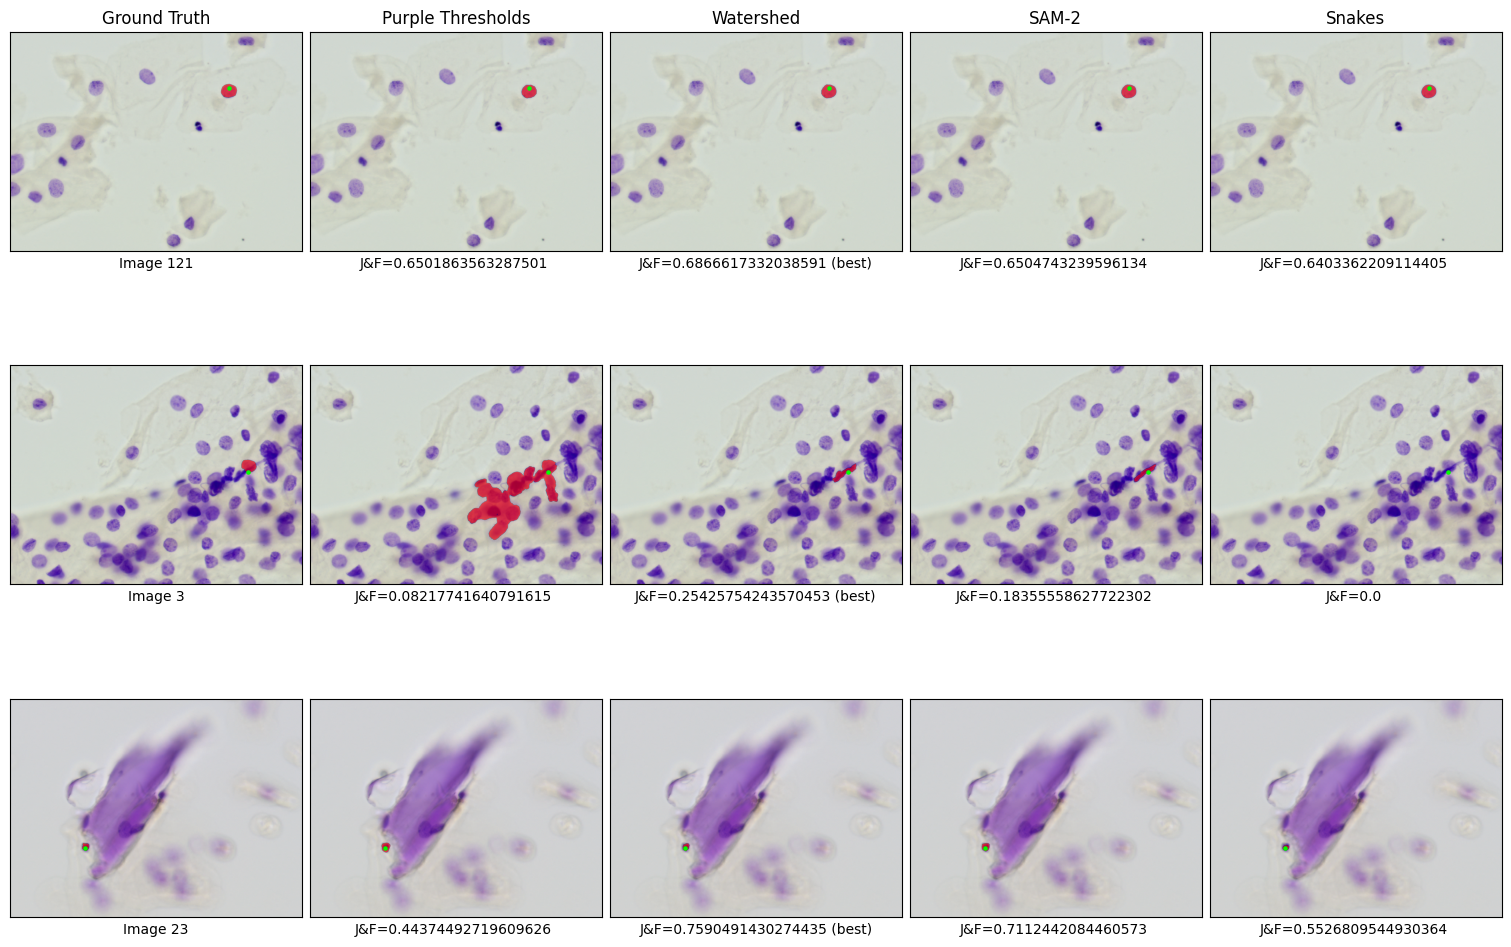

In [44]:
def benchmark(img, ann, click, snakes=False):
    preds = [
        purple_threshold(img, click),
        watershed_segment(img, click, "Sobel"),
        sam2_segment(img, click, None)
    ]

    jfs = [
        compute_j_and_f(ann, preds[0]),
        compute_j_and_f(ann, preds[1]),
        compute_j_and_f(ann, preds[2])
    ]

    if (snakes):
        preds.append(acm_snakes(img, click, init_radius=10, step_radius=10, max_iter=8, tolerance_rate=0.99995))
        jfs.append(compute_j_and_f(ann, preds[3]))

    best_i = -1
    best = -1
    for i in range(0, len(jfs)):
        if jfs[i] > best:
            best = jfs[i]
            best_i = i
        
    return preds, jfs, best_i

def set_metric_ax(ax, img, mask, click, jf, is_best):
    best_txt = "(best)" if is_best else ""
    ax.imshow(img)
    ax.set_xlabel(f"J&F={jf} {best_txt}")
    ax.imshow(colormap[mask])
    ax.scatter(click[0], click[1], color='lime', marker='.', s=20)
    ax.set_xticks([])
    ax.set_yticks([])

test_imgs = get_dataset_imgs("test")
imgs, anns, points, idxs = get_random_batch(test_imgs, batch_size=3, resize_img=None)

fig, axes = plt.subplots(nrows=len(imgs), ncols=5, figsize=(15, 10), layout="constrained")
axes[0, 0].set_title("Ground Truth")
axes[0, 1].set_title("Purple Thresholds")
axes[0, 2].set_title("Watershed")
axes[0, 3].set_title("SAM-2")
axes[0, 4].set_title("Snakes")

colormap = get_colormap(0.6)
for i in range(0, len(imgs)):
    # predict
    img = imgs[i]
    mask = anns[i]
    click = points[i]
    preds, jfs, best_i = benchmark(img, mask, click, snakes=True)

    # GT
    ax = axes[i][0]
    ax.imshow(img)
    ax.set_xlabel(f"Image {idxs[i]}")
    ax.imshow(colormap[mask])
    ax.scatter(click[0], click[1], color='lime', marker='.', s=20)
    ax.set_xticks([])
    ax.set_yticks([])
    
    set_metric_ax(axes[i][1], img, preds[0], click, jfs[0], best_i == 0) # Purple
    set_metric_ax(axes[i][2], img, preds[1], click, jfs[1], best_i == 1) # Water
    set_metric_ax(axes[i][3], img, preds[2], click, jfs[2], best_i == 2) # SAM
    set_metric_ax(axes[i][4], img, preds[3], click, jfs[3], best_i == 3) # Snakes

plt.show()

In [55]:
from datetime import datetime as dt

def print_title(title):
    print(f"[{dt.now()}] {title} -> ", end="")
    
def print_info(vals, best_i):
    line_str = ""
    names = ["Purple T.", "Watershed", "SAM-2"]
    for i in range(0, len(names)):
        line_str += "" if i==0 else "; "
        line_str += f"{names[i]}: {vals[i]}"
        line_str += "*" if i == best_i else ""
    print(line_str)

calc_arr = []
for i in range(0, 10):
    imgs, masks, clicks, idxs = get_random_batch(test_imgs, batch_size=30, resize_img=None)
    for img, mask, click, idx in zip(imgs, masks, clicks, idxs):
        print_title(f"Image {idx}; Point {click}; J&F")
        # predict
        _, jfs, best_i = benchmark(img, mask, click)
        
        # save
        calc_arr.append(jfs)
    
        # show
        print_info(jfs, best_i)
    print()

# calc mean and std
calc_arr = np.array(calc_arr)

means = np.mean(calc_arr, axis=0)
print_title("Mean")
print_info(means, np.argmax(means))

stds = np.std(calc_arr, axis=0)
print_title("STD")
print_info(stds, np.argmin(stds))

[2025-06-25 09:04:45.500263] Image 150; Point [552  99]; J&F -> Purple T.: 0.17833871150926328; Watershed: 0.7385213683687808; SAM-2: 0.7781600277379896*
[2025-06-25 09:04:47.187093] Image 16; Point [926 497]; J&F -> Purple T.: 0.8726448313059576; Watershed: 0.9069699810582768*; SAM-2: 0.8710626573494881
[2025-06-25 09:04:48.865528] Image 6; Point [721 122]; J&F -> Purple T.: 0.5539263017882654; Watershed: 0.8033013086089751*; SAM-2: 0.6190105169963207
[2025-06-25 09:04:50.532548] Image 140; Point [170 383]; J&F -> Purple T.: 0.42474568774878374; Watershed: 0.7806318995701438*; SAM-2: 0.6146817786152934
[2025-06-25 09:04:52.228186] Image 158; Point [371 776]; J&F -> Purple T.: 0.6272759784847792; Watershed: 0.859647737515533*; SAM-2: 0.5895522722586314
[2025-06-25 09:04:53.904143] Image 21; Point [578 770]; J&F -> Purple T.: 0.6491010111173452; Watershed: 0.8884418461869669; SAM-2: 0.9411184580270624*
[2025-06-25 09:04:55.582600] Image 145; Point [1459  624]; J&F -> Purple T.: 0.622400